In [1]:
import torch
from PIL import Image
import requests
from lavis.models import load_model_and_preprocess

c:\Users\dasdi\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


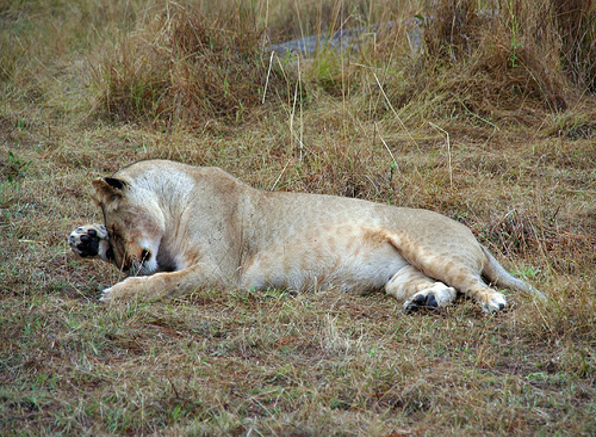

In [2]:
img_url = 'https://storage.googleapis.com/sfr-vision-language-research/LAVIS/assets/merlion.png' 
#raw_image = Image.open(requests.get(img_url, stream=True).raw).convert('RGB')
raw_image = Image.open("C:\\Users\\dasdi\\Desktop\\5.jpeg").convert('RGB')
display(raw_image.resize((596, 437)))

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else "cpu"

In [4]:
torch.cuda.is_available()

True

In [9]:
import torch
import os
from torch.cuda.amp import autocast, GradScaler
from accelerate import Accelerator

torch.cuda.empty_cache()

os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb:128'

accelerator = Accelerator(cpu=True)

def clear_memory():
    torch.cuda.empty_cache()
    torch.cuda.synchronize()

clear_memory()

scaler = GradScaler()

try:
    with autocast():
        model, vis_processors, _ = load_model_and_preprocess(
            name="blip2_t5", model_type="caption_coco_flant5xl", is_eval=True, device="cpu"  # Load on CPU first
        )
    
    if hasattr(model, 'gradient_checkpointing_enable'):
        model.gradient_checkpointing_enable()
    model = accelerator.prepare(model)

except RuntimeError as e:
    print(f"Error during model loading: {e}")
    clear_memory()

Position interpolate from 16x16 to 26x26


Loading checkpoint shards: 100%|██████████| 2/2 [01:12<00:00, 36.29s/it]


In [11]:
print(model.state_dict().keys())

odict_keys(['query_tokens', 'visual_encoder.cls_token', 'visual_encoder.pos_embed', 'visual_encoder.patch_embed.proj.weight', 'visual_encoder.patch_embed.proj.bias', 'visual_encoder.blocks.0.norm1.weight', 'visual_encoder.blocks.0.norm1.bias', 'visual_encoder.blocks.0.attn.q_bias', 'visual_encoder.blocks.0.attn.v_bias', 'visual_encoder.blocks.0.attn.qkv.weight', 'visual_encoder.blocks.0.attn.proj.weight', 'visual_encoder.blocks.0.attn.proj.bias', 'visual_encoder.blocks.0.norm2.weight', 'visual_encoder.blocks.0.norm2.bias', 'visual_encoder.blocks.0.mlp.fc1.weight', 'visual_encoder.blocks.0.mlp.fc1.bias', 'visual_encoder.blocks.0.mlp.fc2.weight', 'visual_encoder.blocks.0.mlp.fc2.bias', 'visual_encoder.blocks.1.norm1.weight', 'visual_encoder.blocks.1.norm1.bias', 'visual_encoder.blocks.1.attn.q_bias', 'visual_encoder.blocks.1.attn.v_bias', 'visual_encoder.blocks.1.attn.qkv.weight', 'visual_encoder.blocks.1.attn.proj.weight', 'visual_encoder.blocks.1.attn.proj.bias', 'visual_encoder.blocks

In [6]:
import pickle
def save_model(model, vis_processors, model_path, components_path):
    torch.save(model.state_dict(), model_path)
    
    components = {
        'vis_processors': vis_processors
    }
    with open(components_path, "wb") as f:
        pickle.dump(components, f)
save_model(model, vis_processors, "model_state_dict_caption_coco_flant5xl.pth", "components_caption_coco_flant5xl.pkl")


In [7]:
import torch
from torchvision import transforms
from PIL import Image

def initialize_vis_processors():
    return {
        'eval': transforms.Compose([
            transforms.Resize((364, 364)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    }

vis_processors = initialize_vis_processors()

if 'eval' in vis_processors:
    preprocessed_image = vis_processors['eval'](raw_image)
    
    image = preprocessed_image.unsqueeze(0)
    
    image = image.to(accelerator.device)

else:
    raise KeyError("'eval' key not found in vis_processors. Available keys: {}".format(vis_processors.keys()))

model = model.to(accelerator.device)

output = model.generate({"image": image})
print(output)

['a lion laying down in a grassy field']


In [ ]:
model.generate({"image": image}, use_nucleus_sampling=True, num_captions=3)

In [6]:
import torch
import os
from torch.cuda.amp import autocast, GradScaler
from accelerate import Accelerator
from lavis.models.blip2_models.blip2_t5 import Blip2T5
import pickle
accelerator = Accelerator(cpu=True)
torch.cuda.empty_cache()

os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb:128'

accelerator = Accelerator(cpu=True)

def clear_memory():
    torch.cuda.empty_cache()
    torch.cuda.synchronize()

clear_memory()

scaler = GradScaler()

def quantize_model(model):
    """
    Apply dynamic quantization to the model.
    """
    model.eval()
    model = torch.quantization.quantize_dynamic(
        model, {torch.nn.Linear}, dtype=torch.qint8
    )
    return model

def apply_svd_decomposition(model, rank=16):
    """
    Apply SVD decomposition to linear layers of the model.
    """
    for _, module in model.named_modules():
        if isinstance(module, torch.nn.Linear):
            # Decompose weight matrix
            U, S, V = torch.svd(module.weight)
            U = U[:, :rank]
            S = S[:rank]
            V = V[:, :rank]
            module.weight = torch.nn.Parameter(U @ torch.diag(S) @ V.t())
    return model

def save_model(model, vis_processors, model_path, components_path):
    torch.save(model.state_dict(), model_path)
    
    components = {
        'vis_processors': vis_processors
    }
    with open(components_path, "wb") as f:
        pickle.dump(components, f)
model = Blip2T5()
model = quantize_model(model)
model = apply_svd_decomposition(model)

save_model(model, vis_processors, "model_state_dict_caption_coco_flant5xl_quantized.pth", "components_caption_coco_flant5xl_quantized.pkl")


Loading checkpoint shards: 100%|██████████| 2/2 [01:14<00:00, 37.03s/it]


In [22]:
from lavis.models import load_model
model = load_model("blip_caption", "base_coco")

100%|██████████| 2.50G/2.50G [02:14<00:00, 19.9MB/s] 


In [7]:
import torch
from torchvision import transforms
from PIL import Image
from lavis.models.blip2_models.blip2_t5 import Blip2T5

def load_model(model_path, components_path, device):
    model = Blip2T5()
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    with open(components_path, 'rb') as f:
        components = pickle.load(f)
    return model, components

# Initialize your device, e.g., CPU or CUDA device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def initialize_vis_processors():
    return {
        'eval': transforms.Compose([
            transforms.Resize((364, 364)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    }

model, components = load_model("model_state_dict_caption_coco_flant5xl_quantized.pth", 
                               "components_caption_coco_flant5xl_quantized.pkl", device)
vis_processors = components.get('vis_processors', initialize_vis_processors())

preprocessed_image = vis_processors['eval'](raw_image)
image = preprocessed_image.unsqueeze(0).to(device)

# Generate the output using the model
output = model.generate({"image": image})
print(output)

Loading checkpoint shards: 100%|██████████| 2/2 [00:40<00:00, 20.50s/it]
c:\Users\dasdi\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\_utils.py:314: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  device=storage.device,


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:27                                                                                   │
│                                                                                                  │
│   24 │   │   ])                                                                                  │
│   25 │   }                                                                                       │
│   26                                                                                             │
│ ❱ 27 model, components = load_model("model_state_dict_caption_coco_flant5xl_quantized.pth",      │
│   28 │   │   │   │   │   │   │      "components_caption_coco_flant5xl_quantized.pkl", device)    │
│   29 vis_processors = components.get('vis_processors', initialize_vis_processors())              │
│   30                                                                                             │
│                                                                                                  │
│ in load_model:8                                                                                  │
│                                                                                                  │
│    5                                                                                             │
│    6 def load_model(model_path, components_path, device):                                        │
│    7 │   model = Blip2T5()                                                                       │
│ ❱  8 │   model.load_state_dict(torch.load(model_path, map_location=device))                      │
│    9 │   model.to(device)                                                                        │
│   10 │   model.eval()                                                                            │
│   11 │   with open(components_path, 'rb') as f:                                                  │
│                                                                                                  │
│ c:\Users\dasdi\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\module │
│ .py:2041 in load_state_dict                                                                      │
│                                                                                                  │
│   2038 │   │   │   │   │   │   ', '.join('"{}"'.format(k) for k in missing_keys)))               │
│   2039 │   │                                                                                     │
│   2040 │   │   if len(error_msgs) > 0:                                                           │
│ ❱ 2041 │   │   │   raise RuntimeError('Error(s) in loading state_dict for {}:\n\t{}'.format(     │
│   2042 │   │   │   │   │   │   │      self.__class__.__name__, "\n\t".join(error_msgs)))         │
│   2043 │   │   return _IncompatibleKeys(missing_keys, unexpected_keys)                           │
│   2044                                                                                           │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
RuntimeError: Error(s) in loading state_dict for Blip2T5:
        Missing key(s) in state_dict: "visual_encoder.blocks.0.attn.qkv.weight", 
"visual_encoder.blocks.0.attn.proj.weight", "visual_encoder.blocks.0.attn.proj.bias", 
"visual_encoder.blocks.0.mlp.fc1.weight", "visual_encoder.blocks.0.mlp.fc1.bias", 
"visual_encoder.blocks.0.mlp.fc2.weight", "visual_encoder.blocks.0.mlp.fc2.bias", 
"visual_encoder.blocks.1.attn.qkv.weight", "visual_encoder.blocks.1.attn.proj.weight", 
"visual_encoder.blocks.1.attn.proj.bias", "visual_encoder.blocks.1.mlp.fc1.weight", 
"visual_encoder.blocks.1.mlp.fc1.bias", "visual_encoder.blocks.1.mlp.fc2.weight", 
"visual_encoder.blocks.1.mlp.fc2.bias", "visual_encoder.blocks.2.attn.qkv.weight", 
"visual_encoder.blocks.2.attn.proj.

In [31]:
from lavis.models.blip2_models.blip2 import Blip2Base
from lavis.models.blip2_models.blip2_t5 import Blip2T5
from lavis.models.base_model import BaseModel


In [35]:
base_model = BaseModel()

In [36]:
blip2_base = Blip2Base()

In [38]:
model = Blip2T5()

Loading checkpoint shards: 100%|██████████| 2/2 [00:58<00:00, 29.25s/it]


In [8]:
print(model.state_dict().keys())


odict_keys(['query_tokens', 'visual_encoder.cls_token', 'visual_encoder.pos_embed', 'visual_encoder.patch_embed.proj.weight', 'visual_encoder.patch_embed.proj.bias', 'visual_encoder.blocks.0.norm1.weight', 'visual_encoder.blocks.0.norm1.bias', 'visual_encoder.blocks.0.attn.q_bias', 'visual_encoder.blocks.0.attn.v_bias', 'visual_encoder.blocks.0.attn.qkv.scale', 'visual_encoder.blocks.0.attn.qkv.zero_point', 'visual_encoder.blocks.0.attn.qkv._packed_params.dtype', 'visual_encoder.blocks.0.attn.qkv._packed_params._packed_params', 'visual_encoder.blocks.0.attn.proj.scale', 'visual_encoder.blocks.0.attn.proj.zero_point', 'visual_encoder.blocks.0.attn.proj._packed_params.dtype', 'visual_encoder.blocks.0.attn.proj._packed_params._packed_params', 'visual_encoder.blocks.0.norm2.weight', 'visual_encoder.blocks.0.norm2.bias', 'visual_encoder.blocks.0.mlp.fc1.scale', 'visual_encoder.blocks.0.mlp.fc1.zero_point', 'visual_encoder.blocks.0.mlp.fc1._packed_params.dtype', 'visual_encoder.blocks.0.mlp.

In [12]:
model

Blip2T5(
  (visual_encoder): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1408, kernel_size=(14, 14), stride=(14, 14))
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (blocks): ModuleList(
      (0-38): 39 x Block(
        (norm1): LayerNorm((1408,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1408, out_features=4224, bias=False)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=1408, out_features=1408, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (drop_path): Identity()
        (norm2): LayerNorm((1408,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=1408, out_features=6144, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=6144, out_features=1408, bias=True)
          (drop): Dropout(p=0.0, inplace=False)
        )
      )
    )
  )
 

: 